# DrugMechDB comparisons to MechRepoNet

In [1]:
from pathlib import Path
from itertools import chain
from collections import defaultdict

import obonet
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt


from data_tools.wiki import get_curi_xrefs
from data_tools.plotting import count_plot_h
from data_tools.plotting import venn2_pretty as venn2

/home/mmayers/sft/miniconda3/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
this_name = '2_dmdb_mrn_analysis'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path('../0_data/external').resolve()
manual_dir = Path('../0_data/manual').resolve()

In [3]:
ind = nx.read_yaml(data_dir.joinpath('indication_paths.yaml'))

In [4]:
mrn_n = pd.read_csv(manual_dir.joinpath('nodes_biolink.csv'), dtype=str)
mrn_n.head(2)

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
0,UBERON:0000002,cervix,AnatomicalEntity,MESH:D002584|UBERON:0000002,NaN,NaN,NaN,NaN
1,UBERON:0000004,human nose,AnatomicalEntity,MESH:D009666|UBERON:0000004,NaN,NaN,NaN,NaN


Found an issues with DrugBank CURIs so we will standardize them all

Luckily (for now) all drugbank id's start with the number 0

In [5]:
mrn_n['id'] = mrn_n['id'].str.replace('DB:0', 'DB:DB0')
mrn_n['xrefs'] = mrn_n['xrefs'].str.replace('DB:0', 'DB:DB0')

In [6]:
mrn_e = pd.read_csv(manual_dir.joinpath('edges_biolink.csv'), dtype=str)
mrn_e.head(2)

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,...,pmids,phase,date,name,name_x,name_y,merge_id,reactome_id,abbrev,type_no_abbv
0,UNII:BTY153760O,NCBIGene:3605,inhibits_CinG,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CinG,inhibits
1,CHEBI:10056,NCBIGene:1129,activates_CaG,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CaG,activates


## Nodes

In [7]:
dmdb_nodes = defaultdict(list)
for p in ind:
    for n in p['nodes']:
        for k in ['id', 'name', 'label']:
            # some strings have a unicode Byte order mark
            # let's just strip it for functionality
            dmdb_nodes[k].append(n[k].replace('\ufeff', ''))
dmdb_nodes = pd.DataFrame(dmdb_nodes)

In [8]:
mrn_n['label'].value_counts()

MacromolecularMachine          136991
ChemicalSubstance               40766
BiologicalProcessOrActivity     21065
Disease                         13961
OrganismTaxon                   12074
GeneFamily                      10807
PhenotypicFeature                5428
Pathway                          5363
AnatomicalEntity                 3580
Name: label, dtype: int64

In [9]:
dmdb_nodes['label'].value_counts()

BiologicalProcess           3117
Protein                     2401
Disease                     2027
Drug                        2007
ChemicalSubstance            869
PhenotypicFeature            510
OrganismTaxon                443
GeneFamily                   399
GrossAnatomicalStructure     313
Pathway                      211
MolecularActivity            199
CellularComponent            171
Cell                         113
MacromolecularComplex         16
Name: label, dtype: int64

In [10]:
dmdb_mn_to_mrn = {
    'Drug': 'ChemicalSubstance',
    'Protein': 'MacromolecularMachine',
    'Disease': 'Disease',
    'BiologicalProcess': 'BiologicalProcessOrActivity',
    'Pathway': 'Pathway',
    'ChemicalSubstance': 'ChemicalSubstance',
    'GrossAnatomicalStructure': 'AnatomicalEntity',
    'MolecularActivity': 'BiologicalProcessOrActivity',
    'OrganismTaxon': 'OrganismTaxon',
    'GeneFamily': 'GeneFamily',
    'CellularComponent': 'AnatomicalEntity',
    'PhenotypicFeature': 'PhenotypicFeature',
    'Cell': 'AnatomicalEntity',
    'MacromolecularComplex': 'MacromolecularMachine'}

In [11]:
def eval_shared(nodes_a, nodes_b):
    nodes_a_ids = set(nodes_a['id'].unique())
    shared_nodes = nodes_b.query('id in @nodes_a_ids')

    return nodes_a_ids, shared_nodes

In [12]:
dmdb_nids, shared_nodes = eval_shared(dmdb_nodes, mrn_n)

In [13]:
dmdb_curis = list(set([nid.split(':')[0] for nid in dmdb_nids]))
dmdb_curis

['GO',
 'UBERON',
 'UniProt',
 'Pfam',
 'CHEBI',
 'InterPro',
 'DB',
 'NCBITaxon',
 'MESH',
 'CL',
 'PR',
 'HP',
 'TIGR',
 'REACT']

In [14]:
dmdb_nodes['id'].nunique()

3417

In [15]:
len(shared_nodes)

1064

In [16]:
curi_xrefs = []
for curi in dmdb_curis:
    this_xrefs = get_curi_xrefs(mrn_n.query('id not in @dmdb_nids'), curi)
    if len(this_xrefs) == 0:
        print(curi)
    curi_xrefs.append(this_xrefs)
curi_xrefs = pd.concat(curi_xrefs)

Pfam
InterPro
CL
PR
TIGR


In [17]:
len(curi_xrefs)

205974

In [18]:
curi_xrefs.head(2)

,id,xrefs
1029,GO:0000002,GO:0000002
1030,GO:0000003,GO:0000003


In [19]:
xrefd_nodes = curi_xrefs.query('xrefs in @dmdb_nids')
len(xrefd_nodes)

1798

In [20]:
xrefd_nodes.nunique()

id       1736
xrefs    1601
dtype: int64

Multiple MRN nodes Xref to the same DMDB Identifier...

In [21]:
xref_counts = xrefd_nodes['xrefs'].value_counts()

multi_xref = xref_counts[xref_counts > 1].index.tolist()
len(multi_xref)

125

In [22]:
multi_node = xrefd_nodes.query('xrefs in @multi_xref')['id'].tolist()
multi_node = mrn_n.query('id in @multi_node')[['id', 'name', 'label', 'xrefs']]

multi_node['label'].value_counts()

Disease                  227
PhenotypicFeature         53
MacromolecularMachine     27
Name: label, dtype: int64

In [23]:
multi_mm = multi_node.query('label == "MacromolecularMachine"')
multi_mm

,id,name,label,xrefs
98925,NCBIGene:13903673,TEM-1,MacromolecularMachine,SYM:D616_p1002|UniProt:P62593
98927,NCBIGene:13906404,beta-lactamase TEM-1,MacromolecularMachine,SYM:blaTEM-1|UniProt:P62593
98930,NCBIGene:13906709,extended spectrum beta lactamase TEM-1,MacromolecularMachine,SYM:blaTEM-1|UniProt:P62593
98935,NCBIGene:13914015,carbapenem-hydrolyzing beta-lactamase KPC-2,MacromolecularMachine,SYM:kpc2|UniProt:Q9F663
98936,NCBIGene:13914665,carbapenem-hydrolyzing beta-lactamase KPC-2,MacromolecularMachine,SYM:D647_p10008|UniProt:Q9F663
98943,NCBIGene:13923837,KPC-2 protein,MacromolecularMachine,SYM:blaKPC-2|UniProt:Q9F663
99539,NCBIGene:15077276,carbapenemase KPC-2,MacromolecularMachine,SYM:blaKPC-2|UniProt:Q9F663
99753,NCBIGene:15564405,class A carbapenemase KPC-2,MacromolecularMachine,SYM:blaKPC-2|UniProt:Q9F663
100457,NCBIGene:1719,DHFR,MacromolecularMachine,ENSG:ENSG00000228716|HGNC:2861|NCBIGene:1719|O...
105731,NCBIGene:17824300,beta-lactamase TEM,MacromolecularMachine,SYM:D616_p107018|UniProt:P62593


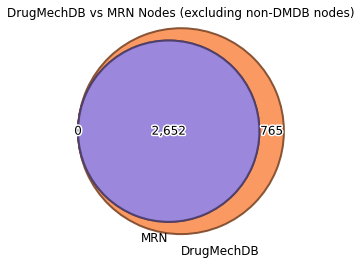

In [24]:
venn2([set(xrefd_nodes['xrefs'].tolist() + shared_nodes['id'].tolist()), set(dmdb_nids)], ['MRN', 'DrugMechDB'])
plt.title('DrugMechDB vs MRN Nodes (excluding non-DMDB nodes)');

In [25]:
def build_node_info():

    dmdb_nids, shared_nodes = eval_shared(dmdb_nodes, mrn_n)
    node_cols = ['id', 'name', 'label']

    node_info = dmdb_nodes.drop_duplicates(subset=['id'], keep='last')
    node_info = node_info.rename(columns={c: 'dmdb_'+c for c in node_cols})
    node_info = node_info.merge(shared_nodes[node_cols].rename(columns={c: 'mrn_'+c for c in node_cols}),
                                left_on='dmdb_id', right_on='mrn_id', how='left')

    tmp = node_info[node_info['mrn_id'].isnull()].drop(['mrn_'+c for c in node_cols], axis=1)
    tmp = tmp.merge(xrefd_nodes.rename(columns={'xrefs': 'dmdb_id', 'id': 'mrn_id'}), on='dmdb_id', how='left')
    tmp = tmp.merge(mrn_n[node_cols].rename(columns={c: 'mrn_'+c for c in node_cols}), on='mrn_id', how='left')

    node_info = pd.concat([node_info.dropna(subset=['mrn_id']), tmp])
    return node_info

In [26]:
node_info = build_node_info()

In [27]:
len(node_info)

3614

In [28]:
node_info.count()

dmdb_id       3614
dmdb_name     3614
dmdb_label    3614
mrn_id        2849
mrn_name      2849
mrn_label     2849
dtype: int64

In [29]:
node_info.nunique()

dmdb_id       3417
dmdb_name     3337
dmdb_label      14
mrn_id        2792
mrn_name      2784
mrn_label        9
dtype: int64

In [30]:
unmapped = node_info[node_info['mrn_id'].isnull()]
unmapped['dmdb_id'].apply(lambda s: s.split(':')[0]).value_counts()

MESH         322
UniProt      119
HP            74
DB            54
UBERON        41
InterPro      38
GO            38
NCBITaxon     34
CHEBI         15
Pfam          12
CL             8
REACT          5
PR             4
TIGR           1
Name: dmdb_id, dtype: int64

In [31]:
def search_name_str(search_str, nodes):
    nnames = nodes['name'].str.lower()
    found = nnames.apply(lambda s: search_str.lower() in s)
    
    return nodes[found]

In [32]:
node_cols = ['id', 'name', 'label']

In [33]:
result = []
for row in unmapped.itertuples():
    lower_name = row.dmdb_name.lower()
    query_type = dmdb_mn_to_mrn[row.dmdb_label]
    
    qr = search_name_str(lower_name, mrn_n.query('label == @query_type'))
    
    if len(qr) == 1:
        qr = qr.copy()
        qr['search_id'] = row.dmdb_id
        qr['search_name'] = row.dmdb_name
        result.append(qr[['id', 'name', 'label', 'search_id', 'search_name']])
        continue
    
    exact_match = qr['name'].str.lower() == lower_name
    if sum(exact_match == 1):
    
        match = qr[exact_match].copy()
        match['search_id'] = row.dmdb_id
        match['search_name'] = row.dmdb_name
        result.append(match[['id', 'name', 'label', 'search_id', 'search_name']])

result = pd.concat(result)
result

,id,name,label,search_id,search_name
44881,CHEBI:64174,carbovir triphosphate,ChemicalSubstance,MESH:C066928,carbovir triphosphate
83197,CHEBI:32183,Tazanolast,ChemicalSubstance,MESH:C106301,tazanolast
81777,CHEBI:134826,clortermine,ChemicalSubstance,DB:DB01527,clortermine
82175,CHEBI:135775,mosapramine,ChemicalSubstance,MESH:C046384,mosapramine
67326,UNII:AVX3D5A4LM,Thyrotropin Alfa,ChemicalSubstance,MESH:D057073,thyrotropin alfa
...,...,...,...,...,...
67400,UNII:P341G6W9NB,deutetrabenazine,ChemicalSubstance,MESH:C000609690,Deutetrabenazine
227561,InterPro:IPR000981,Neurohypophysial hormone,GeneFamily,InterPro:IPR022423,Neurohypophysial hormone
84309,CHEBI:68590,fidaxomicin,ChemicalSubstance,DB:DB08874,Fidaxomicin
38786,CHEBI:28568,piperazine,ChemicalSubstance,DB:DB00592,Piperazine


In [34]:
result[result['name'].str.lower() != result['search_name'].str.lower()]

,id,name,label,search_id,search_name
250013,WD:Q6929,Human cytomegalovirus,OrganismTaxon,NCBITaxon:10358,Cytomegalovirus
64464,MESH:C546561,"butaphosphan, cyanocobalamin drug combination",ChemicalSubstance,DB:DB00115,cyanocobalamin
84368,CHEBI:71025,ulipristal acetate,ChemicalSubstance,DB:DB08867,ulipristal
57896,IKEY:RRNSZQVHVKGKOS-CALFFDBBSA-N,omacetaxine mepesuccinate hydrochloride,ChemicalSubstance,MESH:C001652,omacetaxine mepesuccinate
84411,CHEBI:73139,oseltamivir acid,ChemicalSubstance,DB:DB00198,Oseltamivir
83212,CHEBI:32228,Tinoridine hydrochloride,ChemicalSubstance,MESH:C100290,tinoridine
84720,CHEBI:8229,Pioglitazone hydrochloride,ChemicalSubstance,DB:DB01132,Pioglitazone
961,GO:0000085,mitotic G2 phase,BiologicalProcessOrActivity,GO:0051319,G2 phase
1933,GO:0003095,pressure natriuresis,BiologicalProcessOrActivity,GO:0035819,natriuresis
84852,CHEBI:85982,avibactam sodium,ChemicalSubstance,MESH:C543519,avibactam


In [35]:
# Hand select which are poor matches
drop_idx = [64464, 961, 1933, 190923, 84413, 192337, 16957, 15450, 207012, 26054, 191254, 191391, 1925,
            84575, 193933, 193326]
result = result.drop(drop_idx)

In [36]:
result.count()

id             238
name           238
label          238
search_id      238
search_name    238
dtype: int64

In [37]:
result.nunique()

id             234
name           201
label            8
search_id      202
search_name    200
dtype: int64

Some duplications, lets take a look at them

In [38]:
result[result['name'].duplicated(keep=False)].sort_values('name')

,id,name,label,search_id,search_name
98910,NCBIGene:13874903,Beta-lactamase,MacromolecularMachine,UniProt:P05364,Beta-lactamase
98912,NCBIGene:13875951,Beta-lactamase,MacromolecularMachine,UniProt:P05364,Beta-lactamase
98911,NCBIGene:13875430,Beta-lactamase,MacromolecularMachine,UniProt:P05364,Beta-lactamase
98909,NCBIGene:13874750,Beta-lactamase,MacromolecularMachine,UniProt:P05364,Beta-lactamase
206948,UniProt:C7IVS4,DNA polymerase,MacromolecularMachine,UniProt:P24024,DNA polymerase
206163,UniProt:A0A0K3AUS7,DNA polymerase,MacromolecularMachine,UniProt:P24024,DNA polymerase
206948,UniProt:C7IVS4,DNA polymerase,MacromolecularMachine,UniProt:D4HCU8,DNA polymerase
206163,UniProt:A0A0K3AUS7,DNA polymerase,MacromolecularMachine,UniProt:D4HCU8,DNA polymerase
216670,UniProt:Q49QX8,Tyrosinase,MacromolecularMachine,UniProt:A0A7C6MFF9,Tyrosinase
216855,UniProt:Q6WWJ8,Tyrosinase,MacromolecularMachine,UniProt:A0A7C6MFF9,Tyrosinase


Looks mostly like genes/proteins that come from different species

In [39]:
def update_node_info_with_result():

    found_ids = result['search_id'].unique()
    to_merge = node_info.query('dmdb_id in @found_ids')[['dmdb_'+c for c in node_cols]]

    result_prepped = result[node_cols + ['search_id']].rename(columns={**{c: 'mrn_'+c for c in node_cols}, **{'search_id': 'dmdb_id'}})
    merged = to_merge.merge(result_prepped, on='dmdb_id', how='left')

    return pd.concat([node_info.query('dmdb_id not in @found_ids'), merged]).reset_index(drop=True)

In [40]:
node_info = update_node_info_with_result()

In [41]:
n_mapped = len(node_info.dropna(subset=['mrn_id']).drop_duplicates(subset=['dmdb_id']))
n_dmdb = len(node_info.drop_duplicates(subset=['dmdb_id']))

print('{0:} of {1:} Nodes mapped ({2:1.2%})'.format(n_mapped, n_dmdb, n_mapped/n_dmdb))

2854 of 3417 Nodes mapped (83.52%)


### Do some ontology Mappings to find NEARBY nodes

In [42]:
%%time
url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'
go_graph = obonet.read_obo(url)

CPU times: user 3.67 s, sys: 45 ms, total: 3.72 s
Wall time: 5.13 s


In [43]:
namespace_map = {'cellular_component': 'CellularComponent',
                 'biological_process': 'BiologicalProcess',
                 'molecular_function': 'MolecularActivity'}

In [44]:
goid_to_ns = {_id: namespace_map[props['namespace']] for _id, props in go_graph.nodes.items()}
goid_to_name = {_id: props['name'] for _id, props in go_graph.nodes.items()}

In [45]:
go_graph.nodes['GO:0005262']

{'name': 'calcium channel activity',
 'namespace': 'molecular_function',
 'def': '"Enables the facilitated diffusion of a calcium ion (by an energy-independent process) involving passage through a transmembrane aqueous pore or channel without evidence for a carrier-mediated mechanism." [GOC:mtg_transport, GOC:pr, ISBN:0815340729]',
 'xref': ['Reactome:R-HSA-139854 "IP3R tetramer:I(1,4,5)P3:4xCa2+ transports Ca2+ from platelet dense tubular system to cytosol"',
  'Reactome:R-HSA-139855 "P2X1-mediated entry of Ca++ from plasma"',
  'Reactome:R-HSA-210420 "Ca2+ influx through voltage gated Ca2+ channels"',
  'Reactome:R-HSA-3295579 "TRPs transport extracellular Ca2+ to cytosol"',
  'Reactome:R-HSA-8949145 "VDAC1,2,3 translocate calcium from the cytosol to the mitochondrial intermembrane space"',
  'Reactome:R-HSA-8949178 "MCU translocates calcium from the mitochondrial intermembrane space to the mitochondrial matrix"'],
 'is_a': ['GO:0005261', 'GO:0015085']}

In [46]:
source_path_lengths = nx.single_source_dijkstra_path_length(go_graph, 'GO:0005262')
for (v, l) in source_path_lengths.items():
    if l == 2:
        print(v, goid_to_name[v])

GO:0005216 ion channel activity
GO:0022890 inorganic cation transmembrane transporter activity
GO:0046873 metal ion transmembrane transporter activity


### Build some helper functions to be able to traverse the ontologies faster

In [47]:
def get_nearest_terms(graph, terms, search_space):

    out_relations = defaultdict(list)
    graph_rev = graph.reverse()

    for g in terms:
        try:
            anc, alayer = get_nearest_ancestors(graph, g, search_space)
            dec, dlayer = get_nearest_ancestors(graph_rev, g, search_space)
        except:
            anc = []
            dec = []
            alayer = -1
            dlayer = -1

        for a in anc:
            out_relations['dmdb_id'].append(g)
            out_relations['term'].append(a)
            out_relations['direction'].append('ancestor')
            out_relations['distance'].append(alayer)

        for d in dec:
            out_relations['dmdb_id'].append(g)
            out_relations['term'].append(d)
            out_relations['direction'].append('descendant')
            out_relations['distance'].append(dlayer)
    
    return pd.DataFrame(out_relations)

In [48]:
def filter_nodes_at_distance(source_path_lengths, distance):
    out = []
    for (ancestor, length) in source_path_lengths.items():
        if length == distance:
            out.append(ancestor)
    return out

def get_ancestors_at_layer(graph, node, layer):
    source_path_lengths = nx.single_source_dijkstra_path_length(graph, node)
    return filter_nodes_at_distance(source_path_lengths, layer)

def get_descendants_at_layer(graph, node, layer):
    source_path_lengths = nx.single_source_dijkstra_path_length(graph.reverse(), node)
    return filter_nodes_at_distance(source_path_lengths, layer)

def get_nearest_ancestors(graph, node, search_ids):
    # make search ids a set for fast operations
    if type(search_ids) != set:
        search_ids = set(search_ids)
    
    source_path_lengths = nx.single_source_dijkstra_path_length(graph, node)
    out = []
    steps = 0
    
    # Loop through increasing distances
    while len(out) < 1:
        steps += 1
        layer = filter_nodes_at_distance(source_path_lengths, steps)
        
        # Break the loop if nothing found at given layer
        if len(layer) == 0:
            break
        
        out = list(set(search_ids) & set(layer))
    return out, steps

def get_nearest_descendants(graph, node, search_ids):
    ### Descendents are just ancestors in the other direction
    return get_nearest_ancestors(graph.reverse(), node, search_ids)

def get_nearest_terms(graph, terms, search_space):

    out_relations = defaultdict(list)
    graph_rev = graph.reverse()

    for g in terms:
        try:
            anc, alayer = get_nearest_ancestors(graph, g, search_space)
            dec, dlayer = get_nearest_ancestors(graph_rev, g, search_space)
        except:
            anc = []
            dec = []
            alayer = -1
            dlayer = -1

        for a in anc:
            out_relations['dmdb_id'].append(g)
            out_relations['term'].append(a)
            out_relations['direction'].append('ancestor')
            out_relations['distance'].append(alayer)

        for d in dec:
            out_relations['dmdb_id'].append(g)
            out_relations['term'].append(d)
            out_relations['direction'].append('descendant')
            out_relations['distance'].append(dlayer)
    
    return pd.DataFrame(out_relations)

In [49]:
unmapped_go = set([_id for _id in unmapped['dmdb_id'] if _id.startswith('GO:')])
go_nodes = set([_id for _id in mrn_n['id'] if _id.startswith('GO:')])

In [50]:
go_relations = get_nearest_terms(go_graph, unmapped_go, go_nodes)
go_relations['dmdb_name'] = go_relations['dmdb_id'].map(goid_to_name)
go_relations['term_name'] = go_relations['term'].map(goid_to_name)

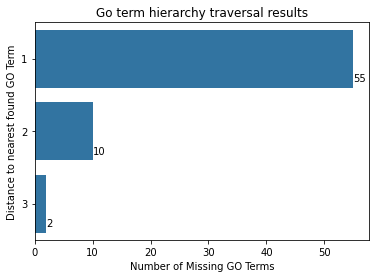

In [51]:
count_plot_h(go_relations['distance'].value_counts(), color=sns.color_palette()[0])
plt.xlabel('Number of Missing GO Terms')
plt.ylabel('Distance to nearest found GO Term')
plt.title('Go term hierarchy traversal results');

In [52]:
go_relations

,dmdb_id,term,direction,distance,dmdb_name,term_name
0,GO:0051319,GO:0022403,ancestor,1,G2 phase,cell cycle phase
1,GO:0051319,GO:0000085,descendant,1,G2 phase,mitotic G2 phase
2,GO:0044825,GO:0008907,ancestor,2,retroviral strand transfer activity,integrase activity
3,GO:0044825,GO:0003824,ancestor,2,retroviral strand transfer activity,catalytic activity
4,GO:0003092,GO:0035811,ancestor,1,renal water retention,negative regulation of urine volume
...,...,...,...,...,...,...
62,GO:0016063,GO:0044249,ancestor,1,rhodopsin biosynthetic process,cellular biosynthetic process
63,GO:0030445,GO:0009277,ancestor,1,yeast-form cell wall,fungal-type cell wall
64,GO:0030164,GO:0044257,ancestor,1,protein denaturation,cellular protein catabolic process
65,GO:0018104,GO:0009252,ancestor,1,peptidoglycan-protein cross-linking,peptidoglycan biosynthetic process


In [53]:
len(go_relations), go_relations['dmdb_id'].nunique()

(67, 35)

In [54]:
no_path_go = set(unmapped_go) - set(go_relations['dmdb_id'])
[(g, goid_to_name.get(g, "Missing")) for g in no_path_go]  

[('GO:0140603', 'Missing'),
 ('GO:0007048', 'Missing'),
 ('GO:005507', 'Missing')]

In [55]:
dmdb_nodes.query('id in @no_path_go')

,id,name,label
708,GO:005507,iron ion homeostasis,BiologicalProcess
6473,GO:0007048,Obsolete oncogenesis,BiologicalProcess
11435,GO:0140603,ATP hydrolysis activity,MolecularActivity
11446,GO:0140603,ATP hydrolysis activity,MolecularActivity


#### See if we can quickly fix issue

In [56]:
name_to_goid = {data['name']: _id for _id, data in go_graph.nodes.items()}

In [57]:
name_to_goid['iron ion homeostasis']

'GO:0055072'

In [58]:
prob = 'iron ion homeostasis'
idx = dmdb_nodes.query('name == @prob').index.tolist()
if idx:
    dmdb_nodes.loc[idx, 'id'] = name_to_goid[prob]

In [59]:
dmdb_ids, shared_nodes = eval_shared(dmdb_nodes, mrn_n)
node_info = build_node_info()
node_info = update_node_info_with_result()

In [60]:
len(shared_nodes)

1065

In [61]:
go_relations.head(20)

,dmdb_id,term,direction,distance,dmdb_name,term_name
0,GO:0051319,GO:0022403,ancestor,1,G2 phase,cell cycle phase
1,GO:0051319,GO:0000085,descendant,1,G2 phase,mitotic G2 phase
2,GO:0044825,GO:0008907,ancestor,2,retroviral strand transfer activity,integrase activity
3,GO:0044825,GO:0003824,ancestor,2,retroviral strand transfer activity,catalytic activity
4,GO:0003092,GO:0035811,ancestor,1,renal water retention,negative regulation of urine volume
5,GO:0140374,GO:0051607,ancestor,1,antiviral innate immune response,defense response to virus
6,GO:0140374,GO:0045087,ancestor,1,antiviral innate immune response,innate immune response
7,GO:1990793,GO:0007269,ancestor,1,"substance P secretion, neurotransmission",neurotransmitter secretion
8,GO:1990793,GO:1990772,ancestor,1,"substance P secretion, neurotransmission",substance P secretion
9,GO:1990793,GO:1904496,descendant,1,"substance P secretion, neurotransmission","positive regulation of substance P secretion, ..."


In [62]:
go_relations.groupby('dmdb_id')['distance'].min()

dmdb_id
GO:0001171    1
GO:0001699    1
GO:0001896    1
GO:0003039    1
GO:0003092    1
GO:0009340    1
GO:0016063    1
GO:0018104    1
GO:0030164    1
GO:0030445    1
GO:0032663    1
GO:0035819    1
GO:0036277    1
GO:0038152    1
GO:0039686    1
GO:0042451    1
GO:0044823    1
GO:0044825    2
GO:0051107    1
GO:0051319    1
GO:0052200    2
GO:0052572    2
GO:0060636    1
GO:0061530    1
GO:0071768    1
GO:0098584    1
GO:0098818    1
GO:0099155    1
GO:0099611    1
GO:0120197    1
GO:0120217    1
GO:0140374    1
GO:1903333    1
GO:1904994    1
GO:1990793    1
Name: distance, dtype: int64

In [63]:
print(
"""
CL
TIGR
Pfam
PR
InterPro
""")


CL
TIGR
Pfam
PR
InterPro



Text(0.5, 0, 'Fraction Found')

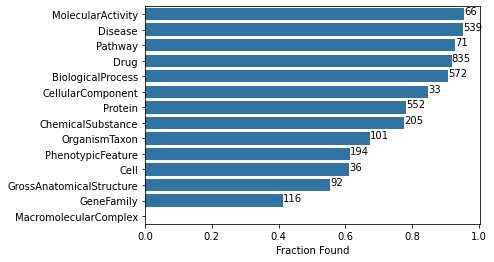

In [64]:
l_c = node_info.drop_duplicates(subset=['dmdb_id'])['dmdb_label'].value_counts()
f_c = node_info.drop_duplicates(subset=['dmdb_id']).dropna(subset=['mrn_id'])['dmdb_label'].value_counts()


frac = (f_c / l_c).sort_values()

order = frac.index

#label = f_c.loc[order].apply(str) + ' / ' + l_c.loc[order].apply(str)

count_plot_h(frac, annotate=l_c, color=sns.color_palette()[0])#, annotate=label)
plt.xlabel('Fraction Found')

## Edges

In [65]:
dmdb_edges = defaultdict(list)

for path in ind:
    for edge in path['links']:
        dmdb_edges['dmdb_start_id'].append(edge['source'].replace('\ufeff', ''))
        dmdb_edges['dmdb_end_id'].append(edge['target'].replace('\ufeff', ''))
        dmdb_edges['type'].append(edge['key'].replace('\ufeff', ''))
dmdb_edges = pd.DataFrame(dmdb_edges)

### 1: Map identifiers to Network

In [66]:
len(dmdb_edges)

12330

In [67]:
edge_info = dmdb_edges.drop_duplicates()

In [68]:
len(edge_info)

6350

In [69]:
id_cols = ['dmdb_id', 'mrn_id']

edge_info = edge_info.merge(node_info[id_cols].rename(columns={c: c.replace('_', '_start_') for c in id_cols}),
                on='dmdb_start_id', how='left')
edge_info = edge_info.merge(node_info[id_cols].rename(columns={c: c.replace('_', '_end_') for c in id_cols}),
                on='dmdb_end_id', how='left')

In [70]:
edge_info.count()

dmdb_start_id    7112
dmdb_end_id      7112
type             7112
mrn_start_id     6117
mrn_end_id       6235
dtype: int64

In [71]:
mrn_tups = set([(r.start_id, r.end_id) for r in mrn_e.itertuples()])

In [72]:
for row in edge_info.itertuples():
    f_tup = (row.mrn_start_id, row.mrn_end_id)
    r_tup = (row.mrn_end_id, row.mrn_start_id)
    
    edge_info.loc[row.Index, 'fwd_in_mrn'] = f_tup in mrn_tups
    edge_info.loc[row.Index, 'rev_in_mrn'] = r_tup in mrn_tups    

In [73]:
edge_info['in_mrn'] = edge_info['fwd_in_mrn'] | edge_info['rev_in_mrn']

In [74]:
n_in_mrn = edge_info['in_mrn'].sum()
n_edges = len(edge_info)

print('{0:} of {1:} mrn_edges found ({2:1.2%})'.format(n_in_mrn, n_edges, n_in_mrn/n_edges))

2000 of 7112 mrn_edges found (28.12%)


In [75]:
nid_to_label = node_info.set_index('dmdb_id')['dmdb_label'].to_dict()

In [76]:
edge_info['start_mn'] = edge_info['dmdb_start_id'].map(nid_to_label)
edge_info['end_mn'] = edge_info['dmdb_end_id'].map(nid_to_label)

In [77]:
edge_info['me'] = edge_info['start_mn'] + ' - ' + edge_info['type'] + ' - ' + edge_info['end_mn']

In [78]:
plt.rcParams['figure.figsize']

[6.0, 4.0]

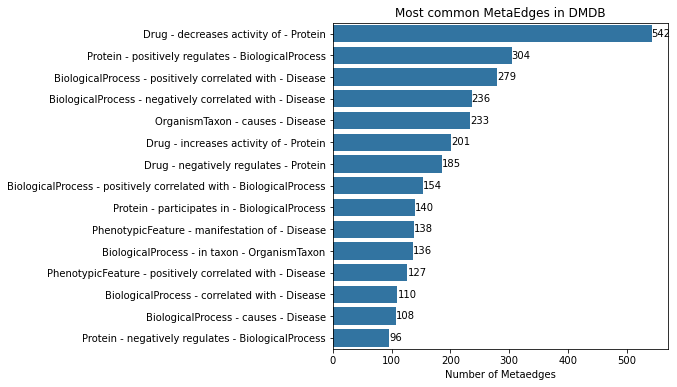

In [79]:
h_num = 15

plt.figure(figsize=(6,6))
count_plot_h(edge_info['me'].value_counts().head(h_num), color=sns.color_palette()[0])

plt.title('Most common MetaEdges in DMDB')
plt.xlabel('Number of Metaedges');

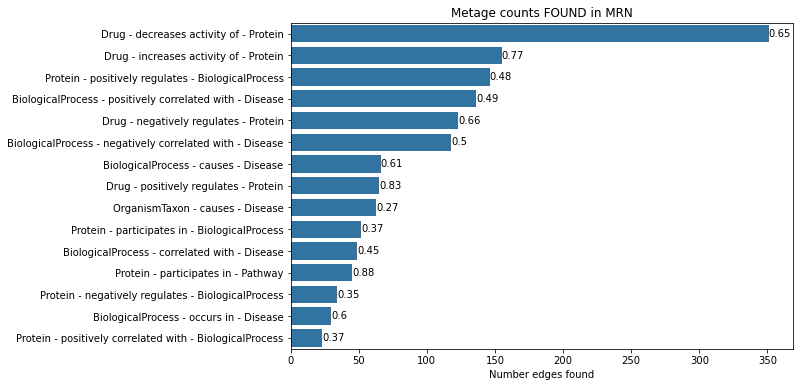

In [80]:
plt.figure(figsize=(9,6))

found = edge_info.query('in_mrn')['me'].value_counts()
total = edge_info['me'].value_counts()
found_pct = found / total

count_plot_h(found.head(h_num), found_pct.loc[found.head(h_num).index], color=sns.color_palette()[0])
plt.title('Metage counts FOUND in MRN')
plt.xlabel('Number edges found');

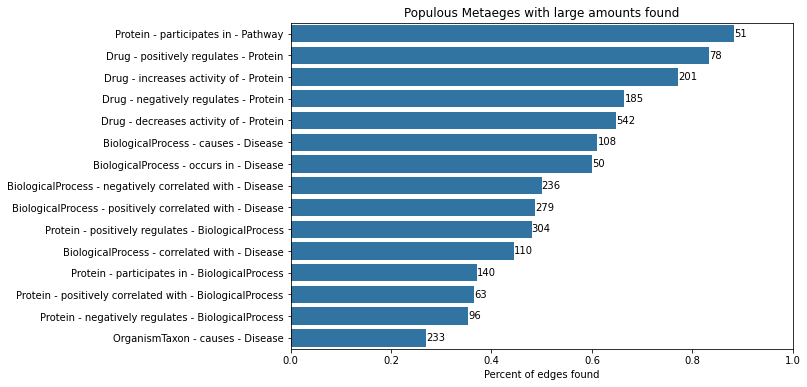

In [81]:
plt.figure(figsize=(9,6))

order = found_pct * total
order = order.sort_values(ascending = False)

count_plot_h(found_pct.loc[order.head(h_num).index], 
             total.loc[order.head(h_num).index], 
             order = sorted(order.head(h_num).index.tolist(), key=lambda o: (1-found_pct.loc[o], order.loc[o]), reverse=False),
             color=sns.color_palette()[0])
plt.xlim([0, 1])
plt.title('Populous Metaeges with large amounts found')
plt.xlabel('Percent of edges found');

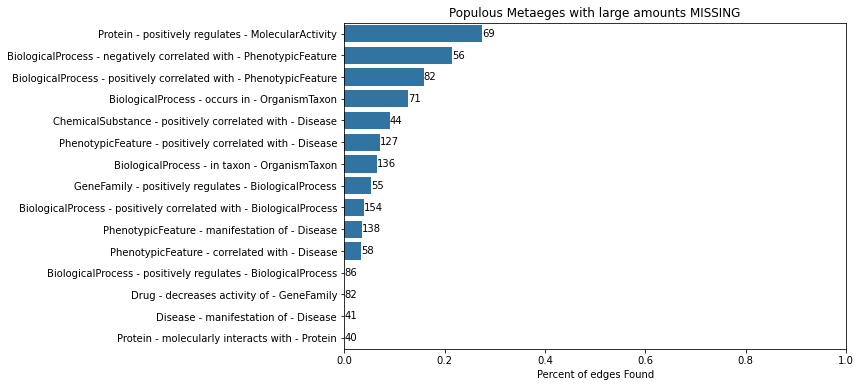

In [82]:
plt.figure(figsize=(9,6))

previously_used = order.head(h_num).index.tolist()

missing = edge_info.query('not in_mrn and me not in @previously_used')['me'].value_counts()
missing_pct = missing / total

new_order = missing_pct * total
new_order = new_order.sort_values(ascending=False)

count_plot_h(1-missing_pct.loc[new_order.head(h_num).index], 
             total.loc[new_order.head(h_num).index], 
             order = sorted(new_order.head(h_num).index.tolist(), key=lambda o: (1-missing_pct.loc[o], new_order.loc[o]), reverse=True),
             color=sns.color_palette()[0])
plt.xlim([0, 1])
plt.title('Populous Metaeges with large amounts MISSING')
plt.xlabel('Percent of edges Found');